In [1]:
import init
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule, MoleculeStoichiometry
from SBMLLint.common import simple_sbml
from SBMLLint.common.reaction import Reaction
from SBMLLint.tools import sbmllint
from SBMLLint.tools import print_reactions

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.linalg import lu, inv
from scipy.optimize import linprog

In [2]:
from games_setup import *
from SBMLLint.common import constants as cn
from SBMLLint.common.simple_sbml import SimpleSBML
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix

from SBMLLint.games.som import SOM
from SBMLLint.games.games_pp import GAMES_PP, SOMStoichiometry, SOMReaction, TOLERANCE
from SBMLLint.games.games_report import GAMESReport, SimplifiedReaction

Current Directory: /Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/notebooks


In [3]:
os.getcwd()

'/Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/notebooks'

In [6]:
# Load relevant bigg models
# bigg constants
BIGG_RESULTS = "results"
BIGG_ID = "bigg_id"
BIGG_GENECOUNT = "gene_count"
BIGG_REACTION_COUNT = "reaction_count"
BIGG_ORGANISM = "organism"
BIGG_METABOLITE_COUNT = "metabolite_count"
import requests
res = requests.get('http://bigg.ucsd.edu/api/v2/models')
bigg_models = res.json()[BIGG_RESULTS]
bigg_ids = [bigg[BIGG_ID] for bigg in bigg_models]
print("number of BiGG models: %d" % len(bigg_models))
bigg_models[:1]

number of BiGG models: 108


[{'bigg_id': 'e_coli_core',
  'gene_count': 137,
  'reaction_count': 95,
  'organism': 'Escherichia coli str. K-12 substr. MG1655',
  'metabolite_count': 72}]

In [7]:
bigg_df = pd.DataFrame(bigg_models).set_index(BIGG_ID)
bigg_df.sort_values(by=BIGG_REACTION_COUNT, 
                    inplace=True)
bigg_df.head()

,gene_count,reaction_count,organism,metabolite_count
bigg_id,,,,
e_coli_core,137,95,Escherichia coli str. K-12 substr. MG1655,72
iAB_RBC_283,346,469,Homo sapiens,342
iIS312,312,519,Trypanosoma cruzi Dm28c,606
iIS312_Amastigote,312,519,Trypanosoma cruzi Dm28c,606
iIS312_Epimastigote,312,519,Trypanosoma cruzi Dm28c,606


In [8]:
bigg_df.tail()

,gene_count,reaction_count,organism,metabolite_count
bigg_id,,,,
RECON1,1905,3741,Homo sapiens,2766
iCHOv1_DG44,1184,3942,Cricetulus griseus,2751
iLB1027_lipid,1027,4456,Phaeodactylum tricornutum CCAP 1055/1,2172
iCHOv1,1766,6663,Cricetulus griseus,4456
Recon3D,2248,10600,Homo sapiens,5835


In [25]:
# define four bigg models depending on size
MODEL_1000 = "iCN718.xml"
MODEL_4000 = "iLB1027_lipid.xml"
MODEL_6000 = "iCHOv1.xml"
MODEL_10000 = "Recon3D.xml"
FOUR_BIGG = [MODEL_1000, MODEL_4000, MODEL_6000, MODEL_10000]
print("------------------------------------------------------")
for bigg in FOUR_BIGG:
  print(bigg_df.loc[bigg[:-4]])
  print("------------------------------------------------------")

------------------------------------------------------
gene_count                                  709
reaction_count                             1015
organism            Acinetobacter baumannii AYE
metabolite_count                            888
Name: iCN718, dtype: object
------------------------------------------------------
gene_count                                           1027
reaction_count                                       4456
organism            Phaeodactylum tricornutum CCAP 1055/1
metabolite_count                                     2172
Name: iLB1027_lipid, dtype: object
------------------------------------------------------
gene_count                        1766
reaction_count                    6663
organism            Cricetulus griseus
metabolite_count                  4456
Name: iCHOv1, dtype: object
------------------------------------------------------
gene_count                  2248
reaction_count             10600
organism            Homo sapiens
metabolite

In [27]:
SAMPLE_MODEL = FOUR_BIGG[0]
fpath = os.path.join(cn.BIGG_DIR, SAMPLE_MODEL)
simple = SimpleSBML()
simple.initialize(fpath)

In [28]:
xgames_start = time.time()
m = GAMES_PP(simple)
res = m.analyze(simple_games=False, error_details=False, suppress_message=True)
xgames_end = time.time()
xgames_time = xgames_end - xgames_start
print(xgames_time)
if res:
  print("xGAMES found an error!")
else:
  print("xGAMES didn't find an error!")

53.78262805938721
xGAMES found an error!


In [29]:
lp_start = time.time()
s = StoichiometryMatrix(simple)
lp_res = s.isConsistent()
lp_end = time.time()
print(lp_end - lp_start)

//anaconda3/envs/sbml_env/lib/python3.6/site-packages/scipy/optimize/_linprog_util.py:763: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


1.9641730785369873


False

In [14]:
m.echelon_errors

[R_SEAHCYSHYD_1:  -> {M_h_c}]

In [20]:
m.echelon_errors

[R_SEAHCYSHYD_1:  -> {M_h_c}]

In [21]:
simple.getReaction("R_SEAHCYSHYD_1")

R_SEAHCYSHYD_1: M_h2o_c + M_seahcys_c -> M_adn_c + M_h_c + M_selhcys_c

In [40]:
simple.getReaction("R_SEAHCYSHYD")

R_SEAHCYSHYD: M_h2o_c + M_seahcys_c -> M_adn_c + M_selhcys_c

In [29]:
simple.getMolecule("M_h2o_c")

M_h2o_c

In [31]:
m.getNode(simple.getMolecule("M_adn_c"))

{M_adn_c}

In [39]:
error_column = m.lower_inverse.T[m.echelon_errors[0].label]
error_loc = error_column.to_numpy().nonzero()
error_reactions = error_column.index[error_loc]
print(error_reactions)
print(error_column[error_loc[0]])

Index(['R_SEAHCYSHYD', 'R_SEAHCYSHYD_1'], dtype='object')
R_SEAHCYSHYD     -1.0
R_SEAHCYSHYD_1    1.0
Name: R_SEAHCYSHYD_1, dtype: float64


In [33]:
select_mat = m.som_stoichiometry_matrix[set(error_reactions)]
lp_mat = select_mat.loc[(select_mat!=0.0).any(axis=1)].T
nmet = lp_mat.shape[1]
# number of reactions
nreac = lp_mat.shape[0]  
#  
b = np.zeros(nreac)
c = np.ones(nmet)
# Linear programming. c is constraint (here, zero), 
# b is vector of possible values for molecule vector. 
lp_res = linprog(c, A_eq=lp_mat, b_eq=b, bounds=(1, None))
lp_res

     con: array([-4.48441284e-12])
     fun: 6.00000000000065
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1.5, 1. , 1. , 1. , 1.5])

In [35]:
lp_mat

,{M_seahcys_c},{M_selhcys_c},{M_adn_c},{M_h_c},{M_h2o_c=M_h2o_e}
R_SEAHCYSHYD_1,-1.0,1.0,1.0,1.0,-1.0


In [73]:
error_series = error_column[error_loc[0]]
error_series = error_series.reindex(index=lp_mat.index)

In [81]:
# for r in error_reactions:
#   print(simple.getReaction(r))
len(error_reactions)

25

In [58]:
original_stoichiometry_matrix["R_SEAHCYSHYD"]

M_hcys__L_c      0.0
M_2mecdp_c       0.0
M_2mahmp_c       0.0
M_aibut_c        0.0
M_dtdp4d6dg_c    0.0
                ... 
M_fru_e          0.0
M_urate_c        0.0
M_trp__L_e       0.0
M_tyrtrna_c      0.0
M_idp_c          0.0
Name: R_SEAHCYSHYD, Length: 852, dtype: float64

In [60]:
s = StoichiometryMatrix(simple)
original_stoichiometry_matrix = s.stoichiometry_matrix
original_stoichiometry_matrix.drop(["R_SEAHCYSHYD_1"], axis=1, inplace=True)
original_stoichiometry_matrix.drop(["R_SEAHCYSHYD"], axis=1, inplace=True)
select_mat = original_stoichiometry_matrix
lp_mat = select_mat.loc[(select_mat!=0.0).any(axis=1)].T
nmet = lp_mat.shape[1]
# number of reactions
nreac = lp_mat.shape[0]  
#  
b = np.zeros(nreac)
c = np.ones(nmet)
# Linear programming. c is constraint (here, zero), 
# b is vector of possible values for molecule vector. 
lp_res = linprog(c, A_eq=lp_mat, b_eq=b, bounds=(1, None))
lp_res.status

2

In [61]:
simple.getReaction("R_SEAHCYSHYD_1")

R_SEAHCYSHYD_1: M_h2o_c + M_seahcys_c -> M_adn_c + M_h_c + M_selhcys_c

In [62]:
simple.getReaction("R_SEAHCYSHYD")

R_SEAHCYSHYD: M_h2o_c + M_seahcys_c -> M_adn_c + M_selhcys_c

In [53]:
original_stoichiometry_matrix.drop(["R_GGTT"], axis=1, inplace=True)

In [45]:
original_stoichiometry_matrix(["R_SEAHCYSHYD_1"]

M_hcys__L_c      0.0
M_2mecdp_c       0.0
M_2mahmp_c       0.0
M_aibut_c        0.0
M_dtdp4d6dg_c    0.0
                ... 
M_fru_e          0.0
M_urate_c        0.0
M_trp__L_e       0.0
M_tyrtrna_c      0.0
M_idp_c          0.0
Name: R_SEAHCYSHYD_1, Length: 852, dtype: float64

(array([ 1.,  1.,  7.,  5., 11.,  5.,  1.,  1.,  1.,  1.,  3.,  5., 58.,
         1.,  0.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   95. ,   305.1,   515.2,   725.3,   935.4,  1145.5,  1355.6,
         1565.7,  1775.8,  1985.9,  2196. ,  2406.1,  2616.2,  2826.3,
         3036.4,  3246.5,  3456.6,  3666.7,  3876.8,  4086.9,  4297. ,
         4507.1,  4717.2,  4927.3,  5137.4,  5347.5,  5557.6,  5767.7,
         5977.8,  6187.9,  6398. ,  6608.1,  6818.2,  7028.3,  7238.4,
         7448.5,  7658.6,  7868.7,  8078.8,  8288.9,  8499. ,  8709.1,
         8919.2,  9129.3,  9339.4,  9549.5,  9759.6,  9969.7, 10179.8,
        10389.9, 10600. ]),
 <a list of 50 Patch objects>)

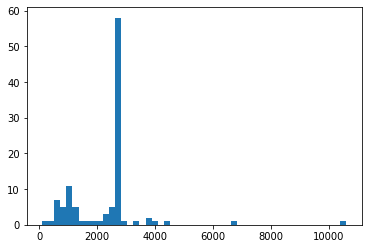

In [9]:
plt.hist(bigg_df[BIGG_REACTION_COUNT], bins=50)

In [10]:
# Download it to BiGG folder - executed so commentized for now
# from urllib.request import urlopen
# for bigg_id in bigg_ids:
#   url_str = "http://bigg.ucsd.edu/static/models/" + bigg_id + ".xml"
#   url_connect = urlopen(url_str)
#   contents = url_connect.read()
#   file = open(os.path.join(cn.BIGG_DIR, bigg_id + ".xml"), 'wb')
#   file.write(contents)
#   file.close()

In [11]:
bigg_file = os.path.join(cn.BIGG_DIR, smallest_bigg+".xml")
bigg_file

'/Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/data/bigg/e_coli_core.xml'

In [47]:
bigg_df.tail()

,gene_count,reaction_count,organism,metabolite_count
bigg_id,,,,
RECON1,1905,3741,Homo sapiens,2766
iCHOv1_DG44,1184,3942,Cricetulus griseus,2751
iLB1027_lipid,1027,4456,Phaeodactylum tricornutum CCAP 1055/1,2172
iCHOv1,1766,6663,Cricetulus griseus,4456
Recon3D,2248,10600,Homo sapiens,5835


In [12]:
type(bigg_df.index)


pandas.core.indexes.base.Index

In [13]:
# initialization test
EXCEPTIONS = ["iAT_PLT_636",
             "iSynCJ816",
             "iRC1080",
             "iYS1720",
             "iMM1415"]
# count = 0
# for f in bigg_df.index:
#   fpath = os.path.join(cn.BIGG_DIR, f+".xml")
#   count += 1
#   if (count%5)==0:
#     print("Model %s, %d(th) reaction has %d reactions" % (f,
#                                                           count,
#                                                           len(simple.reactions)))
#   try:
#     simple = SimpleSBML()
#     simple.initialize(fpath)
#   except:
#     print("Model %s has issue" % f)
#     EXCEPTIONS.append(f)

In [16]:
MODEL_ID = "model_id"
NUM_TOTAL_REACTIONS = "num_total_reactions"
NUM_BDRY_REACTIONS = "num_bdry_reactions"
NUM_UNIUNI_REACTIONS = "num_uniuni_reactions"
NUM_UMMU_REACTIONS = "num_ummu_reactions"
NUM_MULTIMULTI_REACTIONS = "num_multimulti_reactions"
# Checking all models to calculate number of reactions per type 
count = 0
simple = SimpleSBML()
res_list = []
false_errors = set()
for file in bigg_df.index:
  if file in EXCEPTIONS:
    continue
  num_uniuni = 0
  num_ummu = 0
  num_multimulti = 0
  num_bdry = 0
  count += 1
  if (count%10)==0:
    print("we are analyzing Model number:", count)
  simple.initialize(os.path.join(cn.BIGG_DIR, file+".xml"))
  num_dic = {cn.REACTION_1_1: 0,
             cn.REACTION_1_n: 0,
             cn.REACTION_n_1: 0,
             cn.REACTION_n_n: 0,
             cn.REACTION_BOUNDARY: 0
            }  
  for reaction in simple.reactions:
    for category in num_dic.keys():
      if reaction.category == category:
        num_dic[category] += 1
  res_dic = dict({MODEL_ID: file[:-8],
                  NUM_TOTAL_REACTIONS: len(simple.reactions),
                  NUM_BDRY_REACTIONS: num_dic[cn.REACTION_BOUNDARY],
                  NUM_UNIUNI_REACTIONS: num_dic[cn.REACTION_1_1],
                  NUM_UMMU_REACTIONS: num_dic[cn.REACTION_1_n] + num_dic[cn.REACTION_n_1],
                  NUM_MULTIMULTI_REACTIONS: num_dic[cn.REACTION_n_n]})
  sum = res_dic[NUM_BDRY_REACTIONS] + res_dic[NUM_UNIUNI_REACTIONS] + res_dic[NUM_UMMU_REACTIONS] + res_dic[NUM_MULTIMULTI_REACTIONS]
  if sum != res_dic[NUM_TOTAL_REACTIONS]:
    print("Error! The sum doens't match with model %s" % file)
  res_list.append(res_dic)
pd.DataFrame(res_list)

we are analyzing Model number: 10
we are analyzing Model number: 20
we are analyzing Model number: 30
we are analyzing Model number: 40
we are analyzing Model number: 50
we are analyzing Model number: 60
we are analyzing Model number: 70
we are analyzing Model number: 80
we are analyzing Model number: 90
we are analyzing Model number: 100


,model_id,num_total_reactions,num_bdry_reactions,num_uniuni_reactions,num_ummu_reactions,num_multimulti_reactions
0,e_c,95,20,11,6,58
1,iAB,469,99,63,14,293
2,,519,45,110,23,341
3,iIS312_Am,519,45,110,23,341
4,iIS312_Epim,519,45,110,23,341
5,iIS312_Trypom,520,45,110,23,342
6,,554,77,41,36,400
7,,652,84,43,43,482
8,,690,70,48,45,527
9,,743,86,40,46,571


In [25]:
x = reaction_cat[0]
cn.rea

'reaction_1_1'

In [41]:
stats_df = pd.DataFrame(res_list)
reaction_num_cat = [NUM_UNIUNI_REACTIONS,
                    NUM_UMMU_REACTIONS,
                    NUM_MULTIMULTI_REACTIONS
]
reaction_prop = [(stats_df[x]/stats_df[NUM_TOTAL_REACTIONS]).mean()*100
                 for x in
                 reaction_num_cat]
bigg_reaction_prop = pd.Series(reaction_prop, index=reaction_num_cat)
bigg_reaction_prop

num_uniuni_reactions        15.726071
num_ummu_reactions           5.108687
num_multimulti_reactions    66.041247
dtype: float64

In [18]:
# LP method for bigg
# if want to suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

import time
lp_begin = time.time()
data_dir=cn.BIGG_DIR
bigg_files = [f for f in os.listdir(data_dir) if f[-4:] == ".xml"]
# simple = SimpleSBML()
# count = 0
# for f in bigg_df.index[:2]:
#   print("Our model is: %s" % f)
#   count += 1
#   fpath = os.path.join(cn.BIGG_DIR, f+".xml")
#   simple.initialize(fpath)
#   s = StoichiometryMatrix(simple)
#   num_total_reactions = len(simple.reactions)
#   num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
#   print("number of total reactions: %d" % num_total_reactions)
#   print("number of total nonbdry: %d" % num_nonbdry_reactions)
#   consistent = s.isConsistent()
#   if not consistent:
#     print("%s is not consistent! Error detected\n" % f)
#   else:
#     print("%s is consistent" % f)
# lp_end=time.time()
# print("Total LP time for %d models is %f" % (count, lp_end - lp_begin))

In [19]:
bigg_files[:5]

['iCHOv1.xml',
 'iYL1228.xml',
 'iIS312.xml',
 'iSDY_1059.xml',
 'iEC1356_Bl21DE3.xml']

In [18]:
time.time() - lp_begin

13.354275226593018